In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/audio-based-violence-detection-dataset/VSD.xlsx
/kaggle/input/audio-based-violence-detection-dataset/audios_VSD/audios_VSD/angry_20.wav
/kaggle/input/audio-based-violence-detection-dataset/audios_VSD/audios_VSD/angry_043.wav
/kaggle/input/audio-based-violence-detection-dataset/audios_VSD/audios_VSD/angry_07.wav
/kaggle/input/audio-based-violence-detection-dataset/audios_VSD/audios_VSD/angry_141.wav
/kaggle/input/audio-based-violence-detection-dataset/audios_VSD/audios_VSD/angry_122.wav
/kaggle/input/audio-based-violence-detection-dataset/audios_VSD/audios_VSD/angry_049.wav
/kaggle/input/audio-based-violence-detection-dataset/audios_VSD/audios_VSD/angry_061.wav
/kaggle/input/audio-based-violence-detection-dataset/audios_VSD/audios_VSD/angry_162.wav
/kaggle/input/audio-based-violence-detection-dataset/audios_VSD/audios_VSD/angry_094.wav
/kaggle/input/audio-based-violence-detection-dataset/audios_VSD/audios_VSD/angry_022.wav
/kaggle/input/audio-based-violence-detection-datas

In [10]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.io as tfio
import matplotlib.pyplot as plt
import librosa
from pydub import AudioSegment
import io
from tqdm import tqdm
from sklearn.model_selection import train_test_split



In [11]:
df = pd.read_excel("../input/audio-based-violence-detection-dataset/VSD.xlsx",sheet_name='read_dataset')


In [12]:
df.head()

,File_segment_name,Duration,Violence_start,Violence_end,Violence_duration
0,angry_011,117.0,21.0,38.0,17.0
1,angry_011,117.0,40.0,55.0,15.0
2,angry_011,117.0,60.0,79.0,19.0
3,angry_011,117.0,85.0,95.0,10.0
4,angry_011,117.0,101.0,110.0,9.0


Lets check for any null values or duplicates from the data


In [13]:
df.isna().sum()

File_segment_name    0
Duration             0
Violence_start       0
Violence_end         0
Violence_duration    0
dtype: int64

In [14]:
df.duplicated().sum()

0

In [15]:
df.describe()

,Duration,Violence_start,Violence_end,Violence_duration
count,341.000000,341.000000,341.000000,341.000000
mean,173.798208,59.289191,68.236510,8.946962
std,483.313948,62.564069,62.604923,12.588253
min,15.000000,0.000000,0.001000,0.000000
25%,74.000000,13.235000,24.614000,2.508000
50%,108.000000,43.000000,53.002000,4.644000
75%,161.000000,84.254000,91.778000,10.053000
max,4966.000000,395.679000,398.930000,141.260000


We want to normalize the data so lets see how can we do that


In [16]:
df[(6<df['Violence_duration'])]

,File_segment_name,Duration,Violence_start,Violence_end,Violence_duration
0,angry_011,117.0,21.000,38.000,17.000
1,angry_011,117.0,40.000,55.000,15.000
2,angry_011,117.0,60.000,79.000,19.000
3,angry_011,117.0,85.000,95.000,10.000
4,angry_011,117.0,101.000,110.000,9.000
...,...,...,...,...,...
323,angry_204,243.0,191.667,198.726,7.059
324,angry_204,243.0,201.638,208.047,6.409
329,angry_205,49.0,12.957,32.989,20.032
334,angry_211,149.0,67.707,90.369,22.662


In [29]:
def get_mfcc(audio,start=0,end=1):
    y, sr = librosa.load(os.path.join("../input/audio-based-violence-detection-dataset/audios_VSD/audios_VSD",audio+".wav"))
    # Convert time to sample indices
    mfccs = []
    i=0
    start = int(start * sr)
    end = int(end *sr)
    while end-start>=3*sr and i<10:
        mid_end = start + 3* sr
        # Slice the audio
        y_slice = y[start:mid_end]
        # Calculate MFCCs
        ms = librosa.feature.melspectrogram(y=y_slice,sr=sr)
        log_ms = librosa.power_to_db(ms, ref=np.max)
        mfccs.append(log_ms)
        i+=1
        start = mid_end
    return mfccs

In [26]:
df.iloc[0]

File_segment_name    angry_011
Duration                 117.0
Violence_start            21.0
Violence_end              38.0
Violence_duration         17.0
Name: 0, dtype: object

Creating a dataframe with all the data and their mel spectograms


(128, 130)
(128, 130)
(128, 130)
(128, 130)
(128, 130)


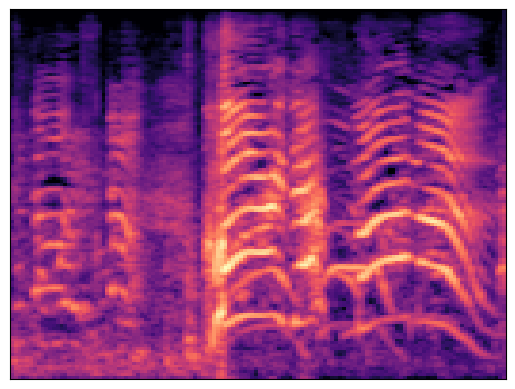

In [32]:
for m in get_mfcc(df.iloc[0,0],df.iloc[0,2],df.iloc[0,3]):
    print(m.shape)
    librosa.display.specshow(m, sr=22050)

In [ ]:
mfcc.shape

lets create a new dataframe such that we get all the violent and non_violent parts from the audio

In [33]:
def new_df(df):
    mfccs = []
    start = 0
    #sets the name for the first row
    name = df.iloc[0,0]
    
    for i in tqdm(range(len(df))):
        if name !=df.iloc[i,0]:
            #if the name changes it means we will still have the end part of the audio thats not in the violent part
            #so we need to go back to get that audio part
            #the start and end of the audio is based on the end of violence and the total duration of the audio
            #get the mfcc for the audio
            mfcc = get_mfcc(df.iloc[i-1,0],df.iloc[i-1,3],df.iloc[i-1,1])
            for m in mfcc:
                mfccs.append({'mfcc':m,'label':0})
            start=0
            name = df.iloc[i,0]
        #get the non violent part of the audio just before the violent starts
        #if its a new name then the start will be 0 and the time when violence start is set as the end
        #get the mfcc for the audio
        mfcc = get_mfcc(name,start,df.iloc[i,2])
        for m in mfcc:
                mfccs.append({'mfcc':m,'label':1})
        #get the violent part of the audio 
        mfcc = get_mfcc(name,df.iloc[i,2],df.iloc[i,3])
        for m in mfcc:
                mfccs.append({'mfcc':m,'label':0})
        start = df.iloc[i,3]
        
#     #for the last part of the loop get the audio file
#     #get the mfcc for the audio
#     mfcc = get_mfcc(df.iloc[-1,0],df.iloc[-1,3],df.iloc[-1,1])
#     mfccs.append({'mfcc':mfcc,'label':0})
    
    df = pd.DataFrame(mfccs)
    return df

In [34]:
df = new_df(df)

100%|██████████| 341/341 [07:03<00:00,  1.24s/it]


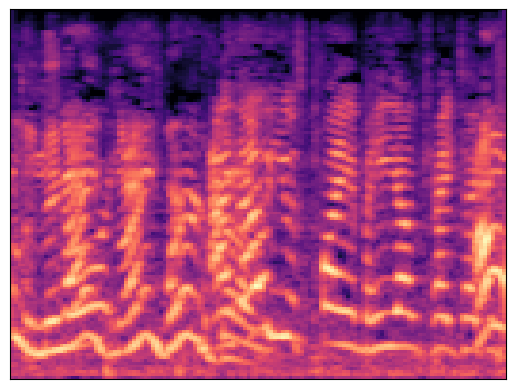

In [35]:
librosa.display.specshow(df.iloc[1,0])


In [36]:
df.isnull().sum()

mfcc     0
label    0
dtype: int64

In [ ]:
df = df.dropna()

In [37]:
df['label'].value_counts()

label
0    1212
1     932
Name: count, dtype: int64

In [38]:
X_train, X_test, y_train, y_test = train_test_split(df['mfcc'], df['label'], test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [39]:
X_train.shape

(1286,)

In [40]:
X_test.shape

(429,)

In [41]:
X_val.shape

(429,)

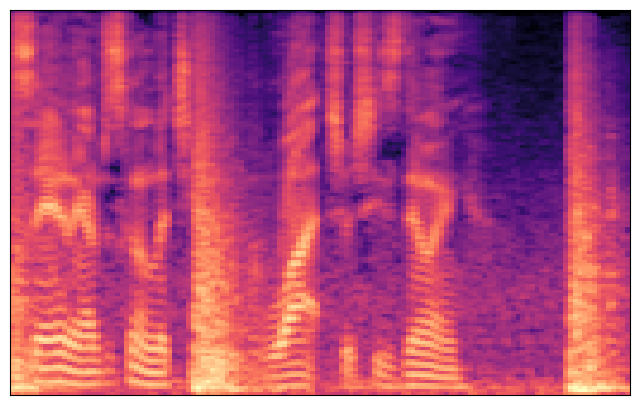

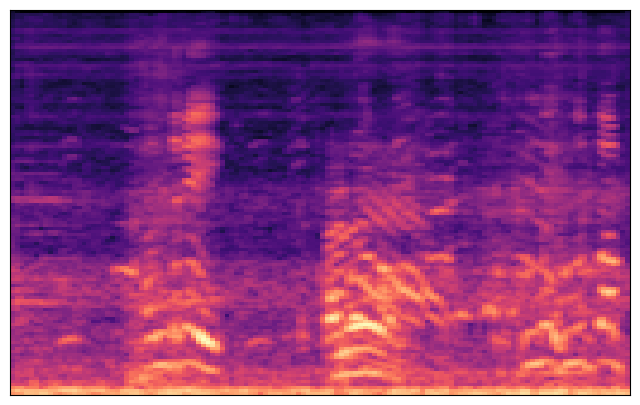

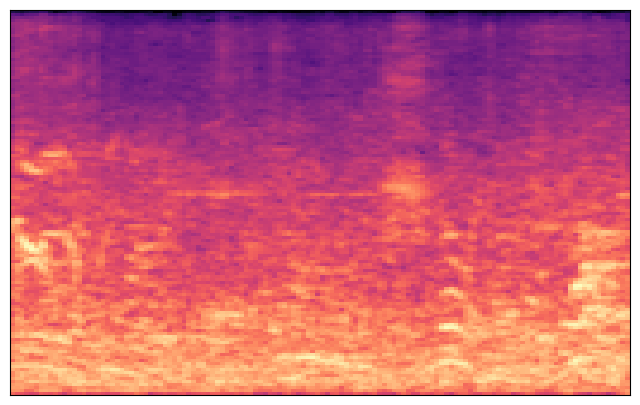

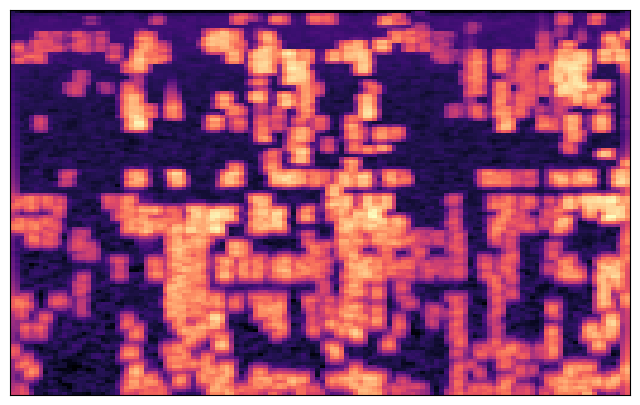

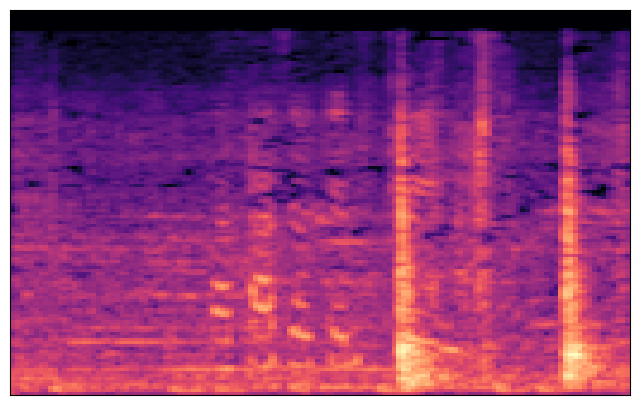

In [42]:
for x in X_train.head():
    plt.figure(figsize=(8,5))
    librosa.display.specshow(x) 

In [43]:
X_train[0].shape

(128, 130)

In [46]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D,AvgPool2D
from keras.layers import Flatten, Dense
from tensorflow.keras import layers, models

model = Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128,130,1)),
    layers.MaxPooling2D(pool_size=(2, 2), padding='same'),  # Adjusted padding parameter
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), padding='same'),  # Adjusted padding parameter
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), padding='same'),  # Adjusted padding parameter
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification with sigmoid activation
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



In [47]:
import numpy as np

# Convert the pandas Series to a numpy array
X_train_array = np.array(X_train.tolist())
X_val_array = np.array(X_val.tolist())

# Reshape the array to match the expected input shape of the model
X_train_reshaped = X_train_array.reshape(X_train_array.shape[0], 128, 130, 1)
X_val_reshaped = X_val_array.reshape(X_val_array.shape[0], 128, 130, 1)


history = model.fit(X_train_reshaped, y_train, batch_size=32, epochs=10, validation_data=(X_val_reshaped, y_val))

Epoch 1/10
41/41 [==============================] - 25s 577ms/step - loss: 1.8301 - accuracy: 0.5498 - val_loss: 0.7681 - val_accuracy: 0.5501
Epoch 2/10
41/41 [==============================] - 23s 553ms/step - loss: 0.6828 - accuracy: 0.5715 - val_loss: 0.6752 - val_accuracy: 0.5455
Epoch 3/10
41/41 [==============================] - 24s 583ms/step - loss: 0.6865 - accuracy: 0.5809 - val_loss: 0.6842 - val_accuracy: 0.5431
Epoch 4/10
41/41 [==============================] - 23s 554ms/step - loss: 0.6879 - accuracy: 0.5809 - val_loss: 2.3443 - val_accuracy: 0.5501
Epoch 5/10
41/41 [==============================] - 22s 543ms/step - loss: 0.7445 - accuracy: 0.5490 - val_loss: 0.6819 - val_accuracy: 0.5478
Epoch 6/10
41/41 [==============================] - 23s 558ms/step - loss: 0.6771 - accuracy: 0.5816 - val_loss: 0.6887 - val_accuracy: 0.6247
Epoch 7/10
41/41 [==============================] - 24s 576ms/step - loss: 0.6799 - accuracy: 0.5708 - val_loss: 0.6749 - val_accuracy: 0.5478

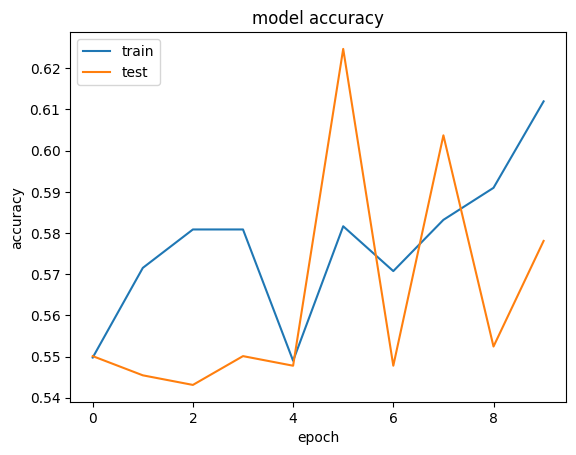

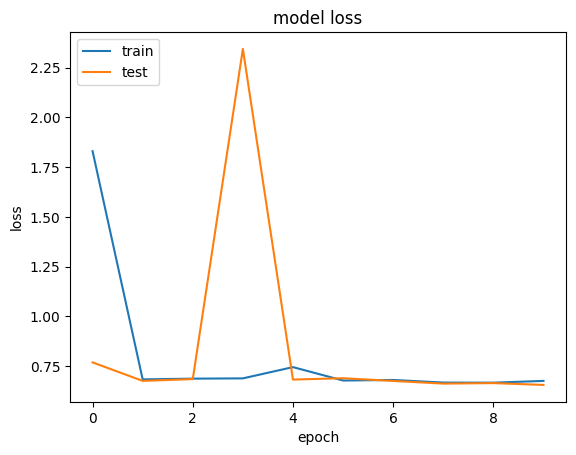

In [48]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()